In [68]:
import pandas as pd
import numpy as np

### Reads in the data and shows an example
Don't worry about calling this more than once, despite the fact that this is a huge dataset, the dataframe only stores the caption and a link to the image.

In [69]:
training_data = pd.read_csv("Train_GCC-training.tsv",sep="\t", header=None)

In [3]:
training_data.head(10)

,0,1
0,a very typical bus station,http://lh6.ggpht.com/-IvRtNLNcG8o/TpFyrudaT6I/...
1,sierra looked stunning in this top and this sk...,http://78.media.tumblr.com/3b133294bdc7c7784b7...
2,young confused girl standing in front of a war...,https://media.gettyimages.com/photos/young-con...
3,interior design of modern living room with fir...,https://thumb1.shutterstock.com/display_pic_wi...
4,cybernetic scene isolated on white background .,https://thumb1.shutterstock.com/display_pic_wi...
5,gangsta rap artist attends sports team vs play...,https://media.gettyimages.com/photos/jayz-atte...
6,the jetty : different types of plants to estab...,https://prismpub.com/wp-content/uploads/2016/1...
7,traditional ornamental floral paisley bandanna .,https://thumb1.shutterstock.com/display_pic_wi...
8,# of the sports team skates against sports tea...,https://media.gettyimages.com/photos/bryan-mcc...
9,by geographical feature category or in the cit...,http://www.robinhoodshow.com/clients/17668/864...


### To show an example, we need to make a request to the web to download the image.

In [14]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg


In [34]:
image_url = training_data.head(1)[1][0]
print(image_url)
image_filename = wget.download(image_url)

http://lh6.ggpht.com/-IvRtNLNcG8o/TpFyrudaT6I/AAAAAAAAM6o/_11MuAAKalQ/IMG_3422.JPG?imgmax=800


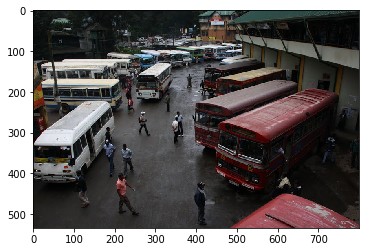

In [37]:
img = mpimg.imread(image_filename)
plt.imshow(img)

In [5]:
## make a funciton to write images to an S3 bucket 
import logging
import boto3
from botocore.exceptions import ClientError
import os

# made a typo when creating the bucket :)
bucket = "caption-images-cs231m"

def open_and_upload_file(file_name, counter):
    """Upload a file to an S3 bucket

    :param file_name: File to upload
    :param bucket: Bucket to upload to
    :param object_name: S3 object name. If not specified then file_name is used
    """
    # get image
    image_filename = "" 
    try: 
        image_filename = wget.download(file_name)
    except:
        print("failed")
        return False
    # Upload the file
    s3_client = boto3.client('s3')
    try:
        response = s3_client.upload_file(image_filename, bucket, "training/" + str(counter))
    # delete file locally after
    except ClientError as e:
        logging.error(e)
        return False
    os.remove(image_filename)
    return True

In [8]:
# just a little confirmation test lol
res = open_and_upload_file(training_data.head(1)[1][0], 0)

In [ ]:
## this cell downloads the images to an s3 bucket! much easier than having it locally
counter = 0
for img in training_data.iterrows():
    res = open_and_upload_file(img[1][1], counter)
    if (counter % 10 == 0):
        print(str(counter) + " processed with status " + str(res))
    counter += 1

In [1]:
import tensorflow as tf

# You'll generate plots of attention in order to see which parts of an image
# our model focuses on during captioning
import matplotlib.pyplot as plt

import collections
import random
import numpy as np
import os
import time
import json
from PIL import Image

In [202]:
# read in small amount of dataset:
from PIL import Image
from io import BytesIO
import numpy as np

bucket_name = "caption-images-cs231m"

def read_image_from_s3(filename):
    """Load image file from s3.

    Parameters
    ----------
    bucket: string
        Bucket name
    key : string
        Path in s3

    Returns
    -------
    np array
        Image array
    """
    s3 = boto3.resource('s3')
    print(filename)

    bucket = s3.Bucket(bucket_name)
    object = bucket.Object(filename)
    response = object.get()
    file_stream = response['Body']
    im = Image.open(file_stream)
    return np.array(im)


In [200]:
# load images from the bucket & reshape to correct size
def load_image(image_path):
    img = tf.convert_to_tensor(read_image_from_s3(str(image_path)))
    img = tf.image.resize(img, (299, 299))
    img = tf.keras.applications.inception_v3.preprocess_input(img)
    return img

In [195]:
# test to make sure the function above works
img = load_image("training/0")
img

<tf.Tensor: shape=(299, 299, 3), dtype=float32, numpy=
array([[[-0.8901961 , -0.84313726, -0.85882354],
        [-0.8838528 , -0.83679396, -0.85248023],
        [-0.8745098 , -0.827451  , -0.84313726],
        ...,
        [-0.6866322 , -0.52192634, -0.561142  ],
        [-0.55746067, -0.40355277, -0.43736947],
        [-0.60346335, -0.45594382, -0.48681635]],

       [[-0.8994426 , -0.85238373, -0.86807   ],
        [-0.8915995 , -0.8445406 , -0.86022687],
        [-0.88375634, -0.83669746, -0.85238373],
        ...,
        [-0.6387657 , -0.49255282, -0.5267321 ],
        [-0.60097814, -0.47689134, -0.5032275 ],
        [-0.7804141 , -0.65632725, -0.68266344]],

       [[-0.90588236, -0.87395895, -0.8820775 ],
        [-0.8980392 , -0.8661158 , -0.8742344 ],
        [-0.8901961 , -0.8582727 , -0.86639124],
        ...,
        [-0.8398093 , -0.7216114 , -0.76110244],
        [-0.83920604, -0.7442621 , -0.7759101 ],
        [-0.78575724, -0.69204104, -0.72368896]],

       ...,

     

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


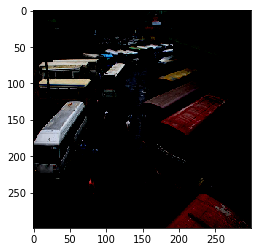

In [25]:
plt.imshow(img[0].numpy())

## get all our beautiful data into a list of captions and img_names :)
skip the ones that have processing issues~


In [119]:
import boto3

s3 = boto3.resource('s3')
my_bucket = s3.Bucket(bucket_name)
image_names = []
captions = []
images = []
for item in my_bucket.objects.filter(Prefix='training/'):
    img
    try:
        img = load_image(item.key)
    except:
        print("could not read", item.key)
        continue
    images.append(img)
    image_names.append(str(item.key))
    caption_index = int(item.key.split("/")[1])
    captions.append(training_data[0][caption_index])

could not read training/1063
could not read training/1065
could not read training/1132
could not read training/1252
could not read training/1262
could not read training/1273
could not read training/1321
could not read training/147
could not read training/156
could not read training/200
could not read training/202
could not read training/244
could not read training/305
could not read training/350
could not read training/386
could not read training/452
could not read training/514
could not read training/602
could not read training/637
could not read training/658
could not read training/713
could not read training/822
could not read training/865
could not read training/9
could not read training/905
could not read training/933
could not read training/944
could not read training/97


In [121]:
# check that sizes match
print(len(image_names), len(captions), len(images))

1164 1164 1164


In [123]:
# prepare tensors
image_dataset = tf.data.Dataset.from_tensor_slices(images)
image_names_dataset = tf.data.Dataset.from_tensor_slices(image_names)
image_dataset_with_path = tf.data.Dataset.zip((image_dataset, image_names_dataset))

In [128]:
# use pretrained imagenet weights
image_model = tf.keras.applications.InceptionV3(include_top=False,
                                                weights='imagenet')
new_input = image_model.input
hidden_layer = image_model.layers[-1].output

image_features_extract_model = tf.keras.Model(new_input, hidden_layer)

In [135]:
for img, path in image_dataset_with_path:
    new_image = tf.expand_dims(img,0)
    batch_features = image_features_extract_model(new_image)
    batch_features = tf.reshape(batch_features,
                              (batch_features.shape[0], -1, batch_features.shape[3]))
    for bf in batch_features:
        path_of_feature = path.numpy().decode("utf-8")
        np.save(path_of_feature, bf.numpy())

## Images are done processing (everything above only needs to be run once okay!)
##### now we process the captions with some tokenization

In [160]:
# Find the maximum length of any caption in our dataset
def calc_max_length(tensor):
    return max(len(t) for t in tensor)

In [161]:
## add start and end to captions
training_captions = []
for c in captions:
    training_captions.append(f"<start> {c} <end>")

In [163]:
# Choose the top 5000 words from the vocabulary
top_k = 5000
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=top_k,
                                                  oov_token="<unk>",
                                                  filters='!"#$%&()*+.,-/:;=?@[\]^_`{|}~ ')
tokenizer.fit_on_texts(training_captions)

In [164]:
tokenizer.word_index['<pad>'] = 0
tokenizer.index_word[0] = '<pad>'

In [165]:
# tokenize captions
# Create the tokenized vectors
train_seqs = tokenizer.texts_to_sequences(training_captions)
# Pad each vector to the max_length of the captions
# If you do not provide a max_length value, pad_sequences calculates it automatically
cap_vector = tf.keras.preprocessing.sequence.pad_sequences(train_seqs, padding='post')
# Calculates the max_length, which is used to store the attention weights
max_length = calc_max_length(train_seqs)

In [166]:
# split data into training and testing
img_to_cap_vector = collections.defaultdict(list)
for img, cap in zip(image_names, cap_vector):
    img_to_cap_vector[img].append(cap)

# Create training and validation sets using an 80-20 split randomly.
img_keys = list(img_to_cap_vector.keys())
random.shuffle(img_keys)

slice_index = int(len(img_keys)*0.8)
img_name_train_keys, img_name_val_keys = img_keys[:slice_index], img_keys[slice_index:]

img_name_train = []
cap_train = []
for imgt in img_name_train_keys:
    capt_len = len(img_to_cap_vector[imgt])
    img_name_train.extend([imgt] * capt_len)
    cap_train.extend(img_to_cap_vector[imgt])

img_name_val = []
cap_val = []
for imgv in img_name_val_keys:
    capv_len = len(img_to_cap_vector[imgv])
    img_name_val.extend([imgv] * capv_len)
    cap_val.extend(img_to_cap_vector[imgv])

In [167]:
# Feel free to change these parameters according to your system's configuration

BATCH_SIZE = 64
BUFFER_SIZE = 1000
embedding_dim = 256
units = 512
vocab_size = top_k + 1
num_steps = len(img_name_train) // BATCH_SIZE
# Shape of the vector extracted from InceptionV3 is (64, 2048)
# These two variables represent that vector shape
features_shape = 2048
attention_features_shape = 64

In [168]:
# Load the numpy files
def map_func(img_name, cap):
    img_tensor = np.load(img_name.decode('utf-8')+'.npy')
    return img_tensor, cap

In [169]:
dataset = tf.data.Dataset.from_tensor_slices((img_name_train, cap_train))

# Use map to load the numpy files in parallel
dataset = dataset.map(lambda item1, item2: tf.numpy_function(
          map_func, [item1, item2], [tf.float32, tf.int32])
          )

# Shuffle and batch
dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
dataset = dataset.prefetch(BUFFER_SIZE)

## actual model

In [170]:
class BahdanauAttention(tf.keras.Model):
    def __init__(self, units):
        super(BahdanauAttention, self).__init__()
        self.W1 = tf.keras.layers.Dense(units)
        self.W2 = tf.keras.layers.Dense(units)
        self.V = tf.keras.layers.Dense(1)

    def call(self, features, hidden):
        # features(CNN_encoder output) shape == (batch_size, 64, embedding_dim)

        # hidden shape == (batch_size, hidden_size)
        # hidden_with_time_axis shape == (batch_size, 1, hidden_size)
        hidden_with_time_axis = tf.expand_dims(hidden, 1)

        # attention_hidden_layer shape == (batch_size, 64, units)
        attention_hidden_layer = (tf.nn.tanh(self.W1(features) +
                                         self.W2(hidden_with_time_axis)))

        # score shape == (batch_size, 64, 1)
        # This gives you an unnormalized score for each image feature.
        score = self.V(attention_hidden_layer)

        # attention_weights shape == (batch_size, 64, 1)
        attention_weights = tf.nn.softmax(score, axis=1)

        # context_vector shape after sum == (batch_size, hidden_size)
        context_vector = attention_weights * features
        context_vector = tf.reduce_sum(context_vector, axis=1)

        return context_vector, attention_weights

In [171]:
class CNN_Encoder(tf.keras.Model):
    # Since you have already extracted the features and dumped it
    # This encoder passes those features through a Fully connected layer
    def __init__(self, embedding_dim):
        super(CNN_Encoder, self).__init__()
        # shape after fc == (batch_size, 64, embedding_dim)
        self.fc = tf.keras.layers.Dense(embedding_dim)

    def call(self, x):
        x = self.fc(x)
        x = tf.nn.relu(x)
        return x

In [172]:
class RNN_Decoder(tf.keras.Model):
    def __init__(self, embedding_dim, units, vocab_size):
        super(RNN_Decoder, self).__init__()
        self.units = units

        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(self.units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')
        self.fc1 = tf.keras.layers.Dense(self.units)
        self.fc2 = tf.keras.layers.Dense(vocab_size)

        self.attention = BahdanauAttention(self.units)

    def call(self, x, features, hidden):
        # defining attention as a separate model
        context_vector, attention_weights = self.attention(features, hidden)

        # x shape after passing through embedding == (batch_size, 1, embedding_dim)
        x = self.embedding(x)

        # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
        x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

        # passing the concatenated vector to the GRU
        output, state = self.gru(x)

        # shape == (batch_size, max_length, hidden_size)
        x = self.fc1(output)

        # x shape == (batch_size * max_length, hidden_size)
        x = tf.reshape(x, (-1, x.shape[2]))

        # output shape == (batch_size * max_length, vocab)
        x = self.fc2(x)

        return x, state, attention_weights

    def reset_state(self, batch_size):
        return tf.zeros((batch_size, self.units))

In [173]:
encoder = CNN_Encoder(embedding_dim)
decoder = RNN_Decoder(embedding_dim, units, vocab_size)

In [174]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')


def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_mean(loss_)

In [175]:
checkpoint_path = "./checkpoints/train"
ckpt = tf.train.Checkpoint(encoder=encoder,
                           decoder=decoder,
                           optimizer=optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

In [176]:
start_epoch = 0
if ckpt_manager.latest_checkpoint:
    start_epoch = int(ckpt_manager.latest_checkpoint.split('-')[-1])
    # restoring the latest checkpoint in checkpoint_path
    ckpt.restore(ckpt_manager.latest_checkpoint)

## let's train... please work!!

In [177]:
# adding this in a separate cell because if you run the training cell
# many times, the loss_plot array will be reset
loss_plot = []

In [178]:
@tf.function
def train_step(img_tensor, target):
    loss = 0

    # initializing the hidden state for each batch
    # because the captions are not related from image to image
    hidden = decoder.reset_state(batch_size=target.shape[0])

    dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * target.shape[0], 1)

    with tf.GradientTape() as tape:
        features = encoder(img_tensor)

        for i in range(1, target.shape[1]):
            # passing the features through the decoder
            predictions, hidden, _ = decoder(dec_input, features, hidden)

            loss += loss_function(target[:, i], predictions)

            # using teacher forcing
            dec_input = tf.expand_dims(target[:, i], 1)

    total_loss = (loss / int(target.shape[1]))

    trainable_variables = encoder.trainable_variables + decoder.trainable_variables

    gradients = tape.gradient(loss, trainable_variables)

    optimizer.apply_gradients(zip(gradients, trainable_variables))

    return loss, total_loss

In [179]:
EPOCHS = 20

for epoch in range(start_epoch, EPOCHS):
    start = time.time()
    total_loss = 0

    for (batch, (img_tensor, target)) in enumerate(dataset):
        batch_loss, t_loss = train_step(img_tensor, target)
        total_loss += t_loss

        if batch % 100 == 0:
            average_batch_loss = batch_loss.numpy()/int(target.shape[1])
            print(f'Epoch {epoch+1} Batch {batch} Loss {average_batch_loss:.4f}')
    # storing the epoch end loss value to plot later
    loss_plot.append(total_loss / num_steps)

    if epoch % 5 == 0:
        ckpt_manager.save()

    print(f'Epoch {epoch+1} Loss {total_loss/num_steps:.6f}')
    print(f'Time taken for 1 epoch {time.time()-start:.2f} sec\n')

Epoch 1 Batch 0 Loss 2.1871
Epoch 1 Loss 1.888965
Time taken for 1 epoch 74.54 sec

Epoch 2 Batch 0 Loss 1.5404
Epoch 2 Loss 1.672759
Time taken for 1 epoch 5.40 sec

Epoch 3 Batch 0 Loss 1.6201
Epoch 3 Loss 1.633108
Time taken for 1 epoch 5.36 sec

Epoch 4 Batch 0 Loss 1.5990
Epoch 4 Loss 1.590171
Time taken for 1 epoch 5.27 sec

Epoch 5 Batch 0 Loss 1.4723
Epoch 5 Loss 1.557682
Time taken for 1 epoch 5.30 sec

Epoch 6 Batch 0 Loss 1.3260
Epoch 6 Loss 1.499721
Time taken for 1 epoch 5.42 sec

Epoch 7 Batch 0 Loss 1.2493
Epoch 7 Loss 1.429255
Time taken for 1 epoch 5.25 sec

Epoch 8 Batch 0 Loss 1.3784
Epoch 8 Loss 1.345915
Time taken for 1 epoch 5.25 sec

Epoch 9 Batch 0 Loss 1.1632
Epoch 9 Loss 1.267569
Time taken for 1 epoch 5.23 sec

Epoch 10 Batch 0 Loss 0.9744
Epoch 10 Loss 1.182287
Time taken for 1 epoch 5.28 sec

Epoch 11 Batch 0 Loss 0.9945
Epoch 11 Loss 1.108436
Time taken for 1 epoch 5.35 sec

Epoch 12 Batch 0 Loss 1.0427
Epoch 12 Loss 1.017814
Time taken for 1 epoch 5.21 se

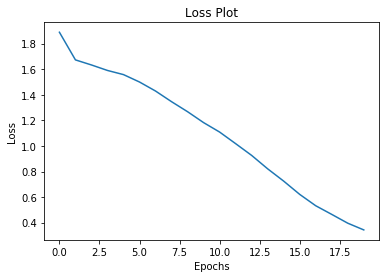

In [180]:
plt.plot(loss_plot)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Plot')
plt.show()

In [221]:
def load_image_local(image_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (299, 299))
    img = tf.keras.applications.inception_v3.preprocess_input(img)
    return img, image_path

In [231]:
def evaluate(image, from_bucket=True):
    attention_plot = np.zeros((max_length, attention_features_shape))

    hidden = decoder.reset_state(batch_size=1)

    temp_input = tf.expand_dims(load_image(image), 0) if from_bucket else tf.expand_dims(load_image_local(image)[0], 0)
    img_tensor_val = image_features_extract_model(temp_input)
    img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0],
                                                 -1,
                                                 img_tensor_val.shape[3]))

    features = encoder(img_tensor_val)

    dec_input = tf.expand_dims([tokenizer.word_index['<start>']], 0)
    result = []

    for i in range(max_length):
        predictions, hidden, attention_weights = decoder(dec_input,
                                                         features,
                                                         hidden)

        attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()

        predicted_id = tf.random.categorical(predictions, 1)[0][0].numpy()
        result.append(tokenizer.index_word[predicted_id])

        if tokenizer.index_word[predicted_id] == '<end>':
            return result, attention_plot

        dec_input = tf.expand_dims([predicted_id], 0)

    attention_plot = attention_plot[:len(result), :]
    return result, attention_plot

In [232]:
def plot_attention(image, result, attention_plot,from_bucket=True):
    temp_image = np.array(read_image_from_s3(image)) if from_bucket else np.array(Image.open(image))

    fig = plt.figure(figsize=(10, 10))

    len_result = len(result)
    for i in range(len_result):
        temp_att = np.resize(attention_plot[i], (8, 8))
        grid_size = max(np.ceil(len_result/2), 2)
        ax = fig.add_subplot(grid_size, grid_size, i+1)
        ax.set_title(result[i])
        img = ax.imshow(temp_image)
        ax.imshow(temp_att, cmap='gray', alpha=0.6, extent=img.get_extent())

    plt.tight_layout()
    plt.show()

t
training/762
Real Caption: <start> teenage boys pitching a tent at the lake in forest <end>
Prediction Caption: celebrity in the winter <end>
training/762


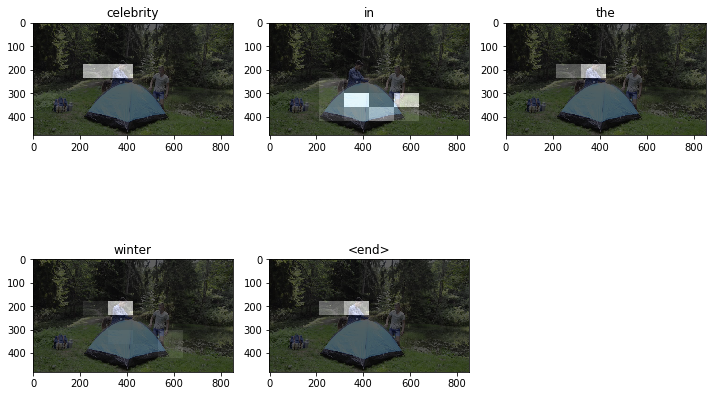

In [248]:
# captions on the validation set
rid = np.random.randint(0, len(img_name_val))
image = img_name_val[rid]
real_caption = ' '.join([tokenizer.index_word[i]
                        for i in cap_val[rid] if i not in [0]])
result, attention_plot = evaluate(image)

print('Real Caption:', real_caption)
print('Prediction Caption:', ' '.join(result))
plot_attention(image, result, attention_plot)

Prediction Caption: happy snowboarder rocks and hot snowboarder lifts his wearer <end>


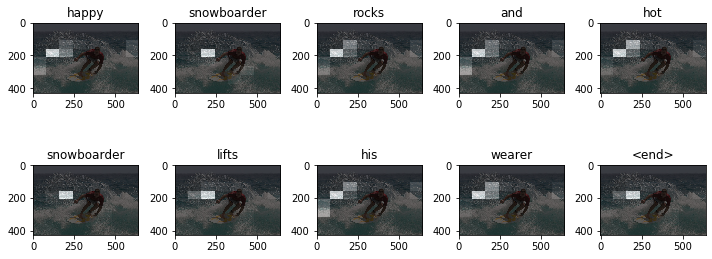

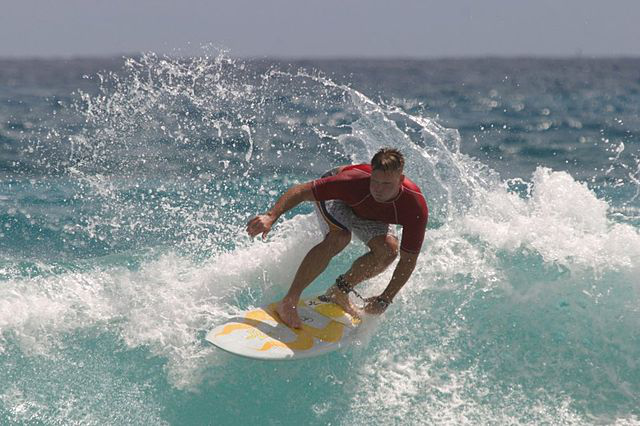

In [247]:
image_url = 'https://tensorflow.org/images/surf.jpg'
image_extension = image_url[-4:]
image_path = tf.keras.utils.get_file('image'+image_extension, origin=image_url)

result, attention_plot = evaluate(image_path, False)
print('Prediction Caption:', ' '.join(result))
plot_attention(image_path, result, attention_plot, False)
# opening the image
Image.open(image_path)